# Multiple linear regression model
### Let's mimic the process of building our trading model of SPY, base on the historical data of different stock markets

In [33]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
# import all stock market data into DataFrame
aord = pd.DataFrame.from_csv('../data/indice/ALLOrdinary.csv')
nikkei = pd.DataFrame.from_csv('../data/indice/Nikkei225.csv')
hsi = pd.DataFrame.from_csv('../data/indice/HSI.csv')
daxi = pd.DataFrame.from_csv('../data/indice/DAXI.csv')
cac40 = pd.DataFrame.from_csv('../data/indice/CAC40.csv')
sp500 = pd.DataFrame.from_csv('../data/indice/SP500.csv')
dji = pd.DataFrame.from_csv('../data/indice/DJI.csv')
nasdaq = pd.DataFrame.from_csv('../data/indice/nasdaq_composite.csv')
spy = pd.DataFrame.from_csv('../data/indice/SPY.csv')

In [36]:
nasdaq.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,2653.909912,2661.500000,2597.810059,2609.629883,2609.629883,2076690000
2008-01-03,2611.959961,2624.270020,2592.179932,2602.679932,2602.679932,1970200000
2008-01-04,2571.080078,2571.080078,2502.679932,2504.649902,2504.649902,2516310000
2008-01-07,2514.149902,2521.620117,2471.229980,2499.459961,2499.459961,2600100000
2008-01-08,2506.969971,2527.419922,2440.510010,2440.510010,2440.510010,2566480000


## Step 1: Data Munging

In [37]:
# Due to the timezone issues, we extract and calculate appropriate stock market data for analysis
# Indicepanel is the DataFrame of our trading model
indices_panel=pd.DataFrame(index=spy.index)

indices_panel['spy'] = spy['Open'].shift(-1) - spy['Open']
indices_panel['spy_lag1'] = indices_panel['spy'].shift(1)
indices_panel['sp500'] = sp500["Open"] - sp500['Open'].shift(1)
indices_panel['nasdaq'] = nasdaq['Open'] - nasdaq['Open'].shift(1)
indices_panel['dji'] = dji['Open'] - dji['Open'].shift(1)

indices_panel['cac40'] = cac40['Open'] - cac40['Open'].shift(1)
indices_panel['daxi'] = daxi['Open'] - daxi['Open'].shift(1)

indices_panel['aord'] = aord['Close'] - aord['Open']
indices_panel['hsi'] = hsi['Close'] - hsi['Open']
indices_panel['nikkei'] = nikkei['Close'] - nikkei['Open']
indices_panel['Price'] = spy['Open']

In [38]:
indices_panel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2008-01-02,-1.619995,NaN,NaN,NaN,NaN,NaN,NaN,-50.100097,-71.679688,NaN,146.529999
2008-01-03,-1.570008,-1.619995,-20.419922,-41.949951,-217.70019,-71.779785,-104.450195,-2.300293,-162.750000,NaN,144.910004
2008-01-04,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,NaN,515.349609,-464.320313,143.339996
2008-01-07,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-27.500000,216.951171,-48.830078,141.809998
2008-01-08,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-33.899902,-354.060547,99.370117,142.080002


In [39]:
# Lets check whether do we have NaN values in indicepanel
indices_panel.isnull().sum()

spy           1
spy_lag1      1
sp500         1
nasdaq        1
dji           1
cac40        30
daxi         53
aord        319
hsi         121
nikkei      145
Price         0
dtype: int64

In [40]:
# We can use method 'fillna()' from dataframe to forward filling the Nan values
# Then we can drop the remaining Nan values
indices_panel = indices_panel.fillna(method='ffill')
indices_panel = indices_panel.dropna()

In [41]:
# Lets check whether do we have Nan values in indicepanel now
indices_panel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [42]:
# save this indicepanel for part 4.5
path_save = '../data/indice/indices_panel.csv'
indices_panel.to_csv(path_save)

In [43]:
print(indices_panel.shape)

(2677, 11)


## Step 2: Data Spliting

In [44]:
# split the data into (1) train set and (2) test set

train = indices_panel.iloc[-2000:-1000, :]
test = indices_panel.iloc[-1000:, :]
print(train.shape, test.shape)

(1000, 11) (1000, 11)


## Step 3: Explore the train data set

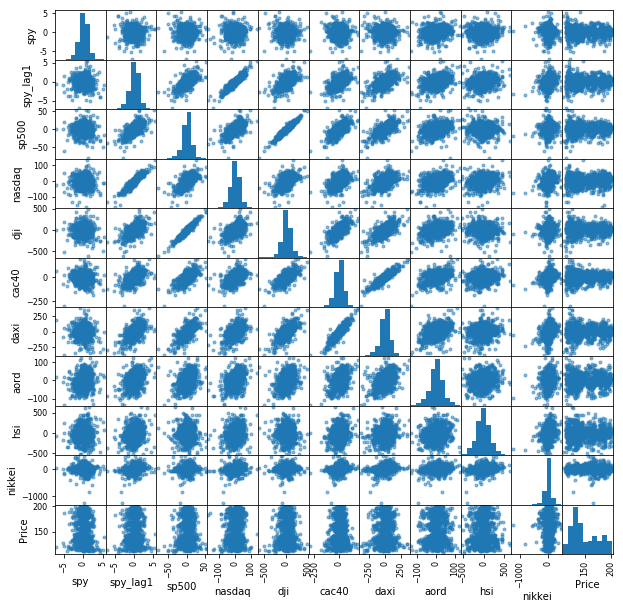

In [45]:
# Generate scatter matrix among all stock markets (and the price of SPY) to observe the association

from pandas.tools.plotting import scatter_matrix
sm = scatter_matrix(train, figsize=(10, 10))

## Step 4: Check the correlation of each index between `SPY`

In [46]:
# Find the indice with largest correlation
corr_array = train.iloc[:, :-1].corr()['spy']
print(corr_array)

spy         1.000000
spy_lag1   -0.011623
sp500      -0.018632
nasdaq      0.012333
dji        -0.037097
cac40      -0.055304
daxi       -0.069735
aord        0.179638
hsi         0.031400
nikkei     -0.035048
Name: spy, dtype: float64


In [47]:
# Show only predictors with `r` being larger than some threshold
corr_array[np.abs(corr_array) > 0.03]

spy       1.000000
dji      -0.037097
cac40    -0.055304
daxi     -0.069735
aord      0.179638
hsi       0.031400
nikkei   -0.035048
Name: spy, dtype: float64

In [48]:
# Train the multiple linear rergession model
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.962
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           1.97e-11
Time:                        21:18:27   Log-Likelihood:                -1617.7
No. Observations:                1000   AIC:                             3255.
Df Residuals:                     990   BIC:                             3305.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0836      0.039      2.138      0.033       0.007       0.160
spy_lag1      -0.1567      0.091     -1.730      0.084      -0.335       0.021
sp500          0.0221      0.014      1.621      0.105      -0.005       0.049
nasdaq         0.0040      0.004      1.066      0.287      -0.003       0.011
dji           -0.0018      0.001     -1.248      0.212      -0.005       0.001
cac40         -0.0003      0.002     -0.153      0.879      -0.004       0.004
aord           0.0093      0.001      7.492      0.000       0.007       0.012
daxi          -0.0025      0.001     -2.387      0.017      -0.005      -0.000
nikkei        -0.0004      0.000     -1.264      0.207      -0.001       0.000
hsi            0.0003      0.000      1.222      0.222      -0.000       0.001
==============================================================================
Omnibus:                       91.018   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.687
Skew:                          -0.450   Prob(JB):                     7.45e-59
Kurtosis:                       5.369   Cond. No.                         405.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### We can see the following:
* $R^2 = 0.067$, which is rather low, but still not bad for daily price difference (`Open tomorrow - Open today`).
* $p(F\text{-stats}) < 0.05$, which means that the model's parameters are statistically significant overall.
* Statistically significant parameters: `intercept`, `aord`, `daxi`. Other variables are _not_ statistically significant.

## Step 5: Make prediction

In [49]:
train['PredictedY'] = lm.predict(train)
test['PredictedY'] = lm.predict(test)

''

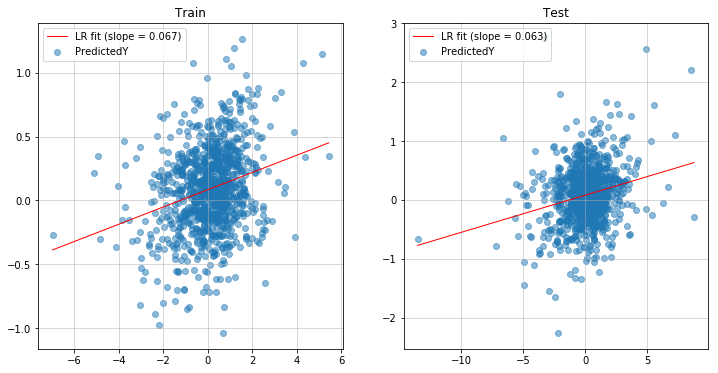

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
poly = np.poly1d(np.polyfit(train['spy'], train['PredictedY'], deg=1))
plt.scatter(train['spy'], train['PredictedY'], alpha=0.5)
plt.plot(train['spy'].sort_values(), poly(train['spy'].sort_values()), color='red', lw=1, label=f'LR fit (slope = {poly[1]:.3f})')
plt.title('Train')
plt.legend(loc=2)
plt.grid(lw=0.5)
plt.subplot(1, 2, 2)
poly = np.poly1d(np.polyfit(test['spy'], test['PredictedY'], deg=1))
plt.scatter(test['spy'], test['PredictedY'], alpha=0.5)
plt.plot(test['spy'].sort_values(), poly(test['spy'].sort_values()), color='red', lw=1, label=f'LR fit (slope = {poly[1]:.3f})')
plt.title('Test')
plt.legend(loc=2)
plt.grid(lw=0.5)
;

## Step 6: Model evaluation - Statistical standard

We can measure the performance of our model using some statistical metrics - **RMSE**, **Adjusted $R^2$ **

In [51]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetrics(data, model, model_k, yname):
    #print(data)
    y_hat = model.predict(data)
    SST = ((data[yname] - data[yname].mean()) ** 2).sum()
    SSR = ((y_hat - data[yname].mean()) ** 2).sum()
    SSE = ((data[yname] - y_hat) ** 2).sum()
    R2 = SSR / SST
    R2_adjusted = 1 - (1 - R2) * (data.shape[0] - 1) / (data.shape[0] - model_k - 1)
    RMSE = (SSE / (data.shape[0] - model_k - 1)) ** 0.5
    return R2_adjusted, RMSE

In [52]:
def summaryTable(train, test, model, model_k, yname):
    r2_train, RMSE_train = adjustedMetrics(train, model, model_k, yname)
    r2_test, RMSE_test = adjustedMetrics(test, model, model_k, yname)
    summary = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    summary['Train'] = [r2_train, RMSE_train]
    summary['Test'] = [r2_test, RMSE_test]
    return summary

In [53]:
# Display the summary table for our model
summaryTable(train, test, lm, 9, 'spy')

,Train,Test
R2,0.059020,0.067248
RMSE,1.226068,1.701291


#### We can see that both `train` and `test` metrics are of the same order. This means that the model does _not_ overfit, which is good.